In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
from typing import Union

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class DecoderLayer(nn.Module):
    """
    Represents one Decoder layer of the Transformer Decoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads, _,
                 bias_mask, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(DecoderLayer, self).__init__()
        
        self.multi_head_attention_dec = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)

        self.multi_head_attention_enc_dec = LongformerSelfAttention(hidden_size=hidden_size, num_attention_heads=num_heads, attention_probs_dropout_prob=attention_dropout, layer_id=_)
      
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='ll', padding = 'left', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha_dec = LayerNorm(hidden_size)
        self.layer_norm_mha_enc = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)

        
    def forward(self, inputs):
        """
        NOTE: Inputs is a tuple consisting of decoder inputs and encoder output
        """
        x, encoder_outputs = inputs
        
        # Layer Normalization before decoder self attention
        x_norm = self.layer_norm_mha_dec(x)
        
        # Masked Multi-head attention
        y = self.multi_head_attention_dec(x_norm, x_norm, x_norm)
        
        # Dropout and residual after self-attention
        x = self.dropout(x + y)

        # Layer Normalization before encoder-decoder attention
        x_norm = self.layer_norm_mha_enc(x)

        # Multi-head encoder-decoder attention
        y, _ = self.multi_head_attention_enc_dec(q=x_norm, k=encoder_outputs, v=encoder_outputs)
        
        # Dropout and residual after encoder-decoder attention
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual after positionwise feed forward layer
        y = self.dropout(x + y)
        
        # Return encoder outputs as well to work with nn.Sequential
        return y, encoder_outputs

In [4]:
def sliding_chunks_no_overlap_matmul_qk(q: torch.Tensor, k: torch.Tensor, w: int, padding_value: float):
    bsz, seqlen_q, num_heads, head_dim = q.size()
    bsz, seqlen_k, num_heads, head_dim = k.size()
    assert seqlen_q % w == 0
#    assert q.size() == k.size()
    # chunk seqlen into non-overlapping chunks of size w
    chunk_q = q.view(bsz, seqlen_q // w, w, num_heads, head_dim)
    chunk_k = k.view(bsz, seqlen_k // w, w, num_heads, head_dim)
    chunk_k_expanded = torch.stack((
        F.pad(chunk_k[:, :-1], (0, 0, 0, 0, 0, 0, 1, 0), value=0.0),
        chunk_k,
        F.pad(chunk_k[:, 1:], (0, 0, 0, 0, 0, 0, 0, 1), value=0.0),
    ), dim=-1)
    diagonal_attn = torch.einsum('bxchd,bychde->bcxhey', (chunk_q, chunk_k_expanded))  # multiply
    return diagonal_attn.reshape(bsz, seqlen_q, num_heads, seqlen_k, 3 * w)

def sliding_chunks_no_overlap_matmul_pv(prob: torch.Tensor, v: torch.Tensor, w: int):
    bsz, seqlen, num_heads, head_dim = v.size()
    seqlen_q = prob.shape[1]
    chunk_prob = prob.view(bsz, seqlen // w, w, num_heads, 3, seqlen_q)
    chunk_v = v.view(bsz, seqlen // w, w, num_heads, head_dim)
    chunk_v_extended = torch.stack((
        F.pad(chunk_v[:, :-1], (0, 0, 0, 0, 0, 0, 1, 0), value=0.0),
        chunk_v,
        F.pad(chunk_v[:, 1:], (0, 0, 0, 0, 0, 0, 0, 1), value=0.0),
    ), dim=-1)
    context = torch.einsum('bcihpd,bcihep->bihed', (chunk_prob, chunk_v_extended))
    return context.reshape(bsz, seqlen_q, num_heads, head_dim)

In [5]:
def sliding_chunks_matmul_qk(q: torch.Tensor, k: torch.Tensor, w: int, padding_value: float):
    '''Matrix multiplicatio of query x key tensors using with a sliding window attention pattern.
    This implementation splits the input into overlapping chunks of size 2w (e.g. 512 for pretrained Longformer)
    with an overlap of size w'''
    bsz, seqlen, num_heads, head_dim = q.size()
    assert seqlen % (w * 2) == 0
    assert q.size() == k.size()

    chunks_count = seqlen // w - 1

    # group bsz and num_heads dimensions into one, then chunk seqlen into chunks of size w * 2
    q = q.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)
    k = k.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)

    chunk_q = _chunk(q, w)
    chunk_k = _chunk(k, w)

    # matrix multipication
    # bcxd: bsz*num_heads x chunks x 2w x head_dim
    # bcyd: bsz*num_heads x chunks x 2w x head_dim
    # bcxy: bsz*num_heads x chunks x 2w x 2w
    chunk_attn = torch.einsum('bcxd,bcyd->bcxy', (chunk_q, chunk_k))  # multiply

    # convert diagonals into columns
    diagonal_chunk_attn = _skew(chunk_attn, direction=(0, 0, 0, 1), padding_value=padding_value)

    # allocate space for the overall attention matrix where the chunks are compined. The last dimension
    # has (w * 2 + 1) columns. The first (w) columns are the w lower triangles (attention from a word to
    # w previous words). The following column is attention score from each word to itself, then
    # followed by w columns for the upper triangle.

    diagonal_attn = diagonal_chunk_attn.new_empty((bsz * num_heads, chunks_count + 1, w, w * 2 + 1))

    # copy parts from diagonal_chunk_attn into the compined matrix of attentions
    # - copying the main diagonal and the upper triangle
    diagonal_attn[:, :-1, :, w:] = diagonal_chunk_attn[:, :, :w, :w + 1]
    diagonal_attn[:, -1, :, w:] = diagonal_chunk_attn[:, -1, w:, :w + 1]
    # - copying the lower triangle
    diagonal_attn[:, 1:, :, :w] = diagonal_chunk_attn[:, :, - (w + 1):-1, w + 1:]
    diagonal_attn[:, 0, 1:w, 1:w] = diagonal_chunk_attn[:, 0, :w - 1, 1 - w:]

    # separate bsz and num_heads dimensions again
    diagonal_attn = diagonal_attn.view(bsz, num_heads, seqlen, 2 * w + 1).transpose(2, 1)

    mask_invalid_locations(diagonal_attn, w, 1, False)
    return diagonal_attn

def _chunk(x, w):
    '''convert into overlapping chunkings. Chunk size = 2w, overlap size = w'''

    # non-overlapping chunks of size = 2w
    x = x.view(x.size(0), x.size(1) // (w * 2), w * 2, x.size(2))

    # use `as_strided` to make the chunks overlap with an overlap size = w
    chunk_size = list(x.size())
    chunk_size[1] = chunk_size[1] * 2 - 1

    chunk_stride = list(x.stride())
    chunk_stride[1] = chunk_stride[1] // 2
    return x.as_strided(size=chunk_size, stride=chunk_stride)

def _skew(x, direction, padding_value):
    '''Convert diagonals into columns (or columns into diagonals depending on `direction`'''
    x_padded = F.pad(x, direction, value=padding_value)
    x_padded = x_padded.view(*x_padded.size()[:-2], x_padded.size(-1), x_padded.size(-2))
    return x_padded

def mask_invalid_locations(input_tensor: torch.Tensor, w: int, d: Union[torch.Tensor, int], autoregressive: bool) -> torch.Tensor:
    affected_seq_len, beginning_mask, ending_mask = _get_invalid_locations_mask(w, d, autoregressive, input_tensor.device)
    seq_len = input_tensor.size(1)
    beginning_input = input_tensor[:, :affected_seq_len, :, :, :w+1]
    beginning_mask = beginning_mask[:, :seq_len].expand(beginning_input.size())
    beginning_input.masked_fill_(beginning_mask, -float('inf'))
    if not autoregressive:
        ending_input = input_tensor[:, -affected_seq_len:, :, :, -(w+1):]
        ending_mask = ending_mask[:, -seq_len:].expand(ending_input.size())
        ending_input.masked_fill_(ending_mask, -float('inf'))
        
def _get_invalid_locations_mask(w: int, d: Union[torch.Tensor,int], autoregressive: bool, device: str):
    if isinstance(d, int):  
        affected_seq_len = w * d
        mask = _get_invalid_locations_mask_fixed_dilation(affected_seq_len, w, d)
        mask = mask[None, :, None, :]
    else:
        affected_seq_len = w * d.max()
        head_masks = []
        d_list = d.cpu().numpy().tolist()
        for d in d_list:
            one_head_mask = _get_invalid_locations_mask_fixed_dilation(affected_seq_len, w, d)
            head_masks.append(one_head_mask)
        mask = torch.stack(head_masks, dim=-2)
        mask = mask[None, :, :, :]

    ending_mask = None if autoregressive else mask.flip(dims=(1, 3)).bool().to(device)
    return affected_seq_len, mask.bool().to(device), ending_mask

def sliding_chunks_matmul_pv(prob: torch.Tensor, v: torch.Tensor, w: int):
    '''Same as sliding_chunks_matmul_qk but for prob and value tensors. It is expecting the same output
    format from sliding_chunks_matmul_qk'''
    bsz, seqlen, num_heads, head_dim = v.size()
    assert seqlen % (w * 2) == 0
    assert prob.size()[:3] == v.size()[:3]
    assert prob.size(3) == 2 * w + 1
    chunks_count = seqlen // w - 1
    # group bsz and num_heads dimensions into one, then chunk seqlen into chunks of size 2w
    chunk_prob = prob.transpose(1, 2).reshape(bsz * num_heads, seqlen // w, w, 2 * w + 1)

    # group bsz and num_heads dimensions into one
    v = v.transpose(1, 2).reshape(bsz * num_heads, seqlen, head_dim)

    # pad seqlen with w at the beginning of the sequence and another w at the end
    padded_v = F.pad(v, (0, 0, w, w), value=-1)

    # chunk padded_v into chunks of size 3w and an overlap of size w
    chunk_v_size = (bsz * num_heads, chunks_count + 1, 3 * w, head_dim)
    chunk_v_stride = padded_v.stride()
    chunk_v_stride = chunk_v_stride[0], w * chunk_v_stride[1], chunk_v_stride[1], chunk_v_stride[2]
    chunk_v = padded_v.as_strided(size=chunk_v_size, stride=chunk_v_stride)

    skewed_prob = _skew2(chunk_prob, padding_value=0)

    context = torch.einsum('bcwd,bcdh->bcwh', (skewed_prob, chunk_v))
    return context.view(bsz, num_heads, seqlen, head_dim).transpose(1, 2)

def _skew2(x, padding_value):
    '''shift every row 1 step to right converting columns into diagonals'''
    # X = B x C x M x L
    B, C, M, L = x.size()
    x = F.pad(x, (0, M + 1), value=padding_value)  # B x C x M x (L+M+1)
    x = x.view(B, C, -1)  # B x C x ML+MM+M
    x = x[:, :, :-M]  # B x C x ML+MM
    x = x.view(B, C, M, M + L)  # B x C, M x L+M
    x = x[:, :, :, :-1]
    return x

def _get_invalid_locations_mask_fixed_dilation(seq_len: int, w: int, d: int):
    diagonals_list = []
    for j in range(-d * w, d, d):
        diagonal_mask = torch.zeros(seq_len, device='cpu', dtype=torch.uint8)
        diagonal_mask[:-j] = 1
        diagonals_list.append(diagonal_mask)
    return torch.stack(diagonals_list, dim=-1)

In [6]:
class LongformerSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, 
                 layer_id, attention_mode='sliding_chunks_no_overlap', autoregressive=False,
                 attention_window=[1] * 2, attention_dilation=[1] * 2):
        super(LongformerSelfAttention, self).__init__()
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_heads = num_attention_heads
        self.head_dim = int(hidden_size / num_attention_heads)
        self.embed_dim = hidden_size

        self.query = nn.Linear(hidden_size, self.embed_dim)
        self.key = nn.Linear(hidden_size, self.embed_dim)
        self.value = nn.Linear(hidden_size, self.embed_dim)

        self.query_global = nn.Linear(hidden_size, self.embed_dim)
        self.key_global = nn.Linear(hidden_size, self.embed_dim)
        self.value_global = nn.Linear(hidden_size, self.embed_dim)

        self.dropout = attention_probs_dropout_prob

        self.layer_id = layer_id
        self.attention_window = attention_window[self.layer_id]
        self.attention_dilation = attention_dilation[self.layer_id]
        self.attention_mode = attention_mode
        self.autoregressive = autoregressive
        assert self.attention_window > 0
        assert self.attention_dilation > 0
        assert self.attention_mode in ['tvm', 'sliding_chunks', 'sliding_chunks_no_overlap']
        if self.attention_mode in ['sliding_chunks', 'sliding_chunks_no_overlap']:
            assert not self.autoregressive  # not supported
            assert self.attention_dilation == 1  # dilation is not supported

    def forward(
        self,
        q,
        k,
        v,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        output_attentions=False,
    ):
        '''
        The `attention_mask` is changed in `BertModel.forward` from 0, 1, 2 to
            -ve: no attention
              0: local attention
            +ve: global attention
        '''
        assert encoder_hidden_states is None, "`encoder_hidden_states` is not supported and should be None"
        assert encoder_attention_mask is None, "`encoder_attention_mask` is not supported and shiould be None"

        if attention_mask is not None:
            attention_mask = attention_mask.squeeze(dim=2).squeeze(dim=1)
            key_padding_mask = attention_mask < 0
            extra_attention_mask = attention_mask > 0
            remove_from_windowed_attention_mask = attention_mask != 0

            num_extra_indices_per_batch = extra_attention_mask.long().sum(dim=1)
            max_num_extra_indices_per_batch = num_extra_indices_per_batch.max()
            if max_num_extra_indices_per_batch <= 0:
                extra_attention_mask = None
            else:
                # To support the case of variable number of global attention in the rows of a batch,
                # we use the following three selection masks to select global attention embeddings
                # in a 3d tensor and pad it to `max_num_extra_indices_per_batch`
                # 1) selecting embeddings that correspond to global attention
                extra_attention_mask_nonzeros = extra_attention_mask.nonzero(as_tuple=True)
                zero_to_max_range = torch.arange(0, max_num_extra_indices_per_batch,
                                                 device=num_extra_indices_per_batch.device)
                # mask indicating which values are actually going to be padding
                selection_padding_mask = zero_to_max_range < num_extra_indices_per_batch.unsqueeze(dim=-1)
                # 2) location of the non-padding values in the selected global attention
                selection_padding_mask_nonzeros = selection_padding_mask.nonzero(as_tuple=True)
                # 3) location of the padding values in the selected global attention
                selection_padding_mask_zeros = (selection_padding_mask == 0).nonzero(as_tuple=True)
        else:
            remove_from_windowed_attention_mask = None
            extra_attention_mask = None
            key_padding_mask = None

        q =q.transpose(0, 1)
        k =k.transpose(0, 1)
        v =v.transpose(0, 1)
        seq_len_q, bsz, embed_dim = q.size()
        seq_len_k, bsz, embed_dim = k.size()
        seq_len_v, bsz, embed_dim = v.size()
        assert embed_dim == self.embed_dim
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)
        q /= math.sqrt(self.head_dim)

        q = q.view(seq_len_q, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        k = k.view(seq_len_k, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        # attn_weights = (bsz, seq_len, num_heads, window*2+1)
        if self.attention_mode == 'tvm':
            q = q.float().contiguous()
            k = k.float().contiguous()
            attn_weights = diagonaled_mm_tvm(q, k, self.attention_window, self.attention_dilation, False, 0, False)
        elif self.attention_mode == "sliding_chunks":
            attn_weights = sliding_chunks_matmul_qk(q, k, self.attention_window, padding_value=0)
        elif self.attention_mode == "sliding_chunks_no_overlap":
            attn_weights = sliding_chunks_no_overlap_matmul_qk(q, k, self.attention_window, padding_value=0)
        else:
            raise False
        mask_invalid_locations(attn_weights, self.attention_window, self.attention_dilation, False)
        if remove_from_windowed_attention_mask is not None:
            # This implementation is fast and takes very little memory because num_heads x hidden_size = 1
            # from (bsz x seq_len) to (bsz x seq_len x num_heads x hidden_size)
            remove_from_windowed_attention_mask = remove_from_windowed_attention_mask.unsqueeze(dim=-1).unsqueeze(dim=-1)
            # cast to float/half then replace 1's with -inf
            float_mask = remove_from_windowed_attention_mask.type_as(q).masked_fill(remove_from_windowed_attention_mask, -10000.0)
            repeat_size = 1 if isinstance(self.attention_dilation, int) else len(self.attention_dilation)
            float_mask = float_mask.repeat(1, 1, repeat_size, 1)
            ones = float_mask.new_ones(size=float_mask.size())  # tensor of ones
            # diagonal mask with zeros everywhere and -inf inplace of padding
            if self.attention_mode == 'tvm':
                d_mask = diagonaled_mm_tvm(ones, float_mask, self.attention_window, self.attention_dilation, False, 0, False)
            elif self.attention_mode == "sliding_chunks":
                d_mask = sliding_chunks_matmul_qk(ones, float_mask, self.attention_window, padding_value=0)
            elif self.attention_mode == "sliding_chunks_no_overlap":
                d_mask = sliding_chunks_no_overlap_matmul_qk(ones, float_mask, self.attention_window, padding_value=0)

            attn_weights += d_mask
            
        assert list(attn_weights.size())[:3] == [bsz, seq_len_q, self.num_heads]
        assert attn_weights.size(dim=4) in [self.attention_window * 2 + 1, self.attention_window * 3]

        # the extra attention
        if extra_attention_mask is not None:
            selected_k = k.new_zeros(bsz, max_num_extra_indices_per_batch, self.num_heads, self.head_dim)
            selected_k[selection_padding_mask_nonzeros] = k[extra_attention_mask_nonzeros]
            # (bsz, seq_len, num_heads, max_num_extra_indices_per_batch)
            selected_attn_weights = torch.einsum('blhd,bshd->blhs', (q, selected_k))
            selected_attn_weights[selection_padding_mask_zeros[0], :, :, selection_padding_mask_zeros[1]] = -10000
            # concat to attn_weights
            # (bsz, seq_len, num_heads, extra attention count + 2*window+1)
            attn_weights = torch.cat((selected_attn_weights, attn_weights), dim=-1)
        attn_weights_float = F.softmax(attn_weights, dim=-1, dtype=torch.float32)  # use fp32 for numerical stability
        if key_padding_mask is not None:
            # softmax sometimes inserts NaN if all positions are masked, replace them with 0
            attn_weights_float = torch.masked_fill(attn_weights_float, key_padding_mask.unsqueeze(-1).unsqueeze(-1), 0.0)
        attn_weights = attn_weights_float.type_as(attn_weights)
        attn_probs = F.dropout(attn_weights_float.type_as(attn_weights), p=self.dropout, training=self.training)
        v = v.view(seq_len_v, bsz, self.num_heads, self.head_dim).transpose(0, 1)
        attn = 0
        if extra_attention_mask is not None:
            selected_attn_probs = attn_probs.narrow(-1, 0, max_num_extra_indices_per_batch)
            selected_v = v.new_zeros(bsz, max_num_extra_indices_per_batch, self.num_heads, self.head_dim)
            selected_v[selection_padding_mask_nonzeros] = v[extra_attention_mask_nonzeros]
            # use `matmul` because `einsum` crashes sometimes with fp16
            # attn = torch.einsum('blhs,bshd->blhd', (selected_attn_probs, selected_v))
            attn = torch.matmul(selected_attn_probs.transpose(1, 2), selected_v.transpose(1, 2).type_as(selected_attn_probs)).transpose(1, 2)
            attn_probs = attn_probs.narrow(-1, max_num_extra_indices_per_batch, attn_probs.size(-1) - max_num_extra_indices_per_batch).contiguous()

        if self.attention_mode == 'tvm':
            v = v.float().contiguous()
            attn += diagonaled_mm_tvm(attn_probs, v, self.attention_window, self.attention_dilation, True, 0, False)
        elif self.attention_mode == "sliding_chunks":
            attn += sliding_chunks_matmul_pv(attn_probs, v, self.attention_window)
        elif self.attention_mode == "sliding_chunks_no_overlap":
            attn += sliding_chunks_no_overlap_matmul_pv(attn_probs, v, self.attention_window)
        else:
            raise False

        attn = attn.type_as(q)
        assert list(attn.size()) == [bsz, seq_len_q, self.num_heads, self.head_dim]
        attn = attn.transpose(0, 1).reshape(seq_len_q, bsz, embed_dim).contiguous()

        # For this case, we'll just recompute the attention for these indices
        # and overwrite the attn tensor. TODO: remove the redundant computation
        if extra_attention_mask is not None:
            selected_hidden_states = hidden_states.new_zeros(max_num_extra_indices_per_batch, bsz, embed_dim)
            selected_hidden_states[selection_padding_mask_nonzeros[::-1]] = hidden_states[extra_attention_mask_nonzeros[::-1]]

            q = self.query_global(selected_hidden_states)
            k = self.key_global(hidden_states)
            v = self.value_global(hidden_states)
            q /= math.sqrt(self.head_dim)

            q = q.contiguous().view(max_num_extra_indices_per_batch, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # (bsz*self.num_heads, max_num_extra_indices_per_batch, head_dim)
            k = k.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # bsz * self.num_heads, seq_len, head_dim)
            v = v.contiguous().view(-1, bsz * self.num_heads, self.head_dim).transpose(0, 1)  # bsz * self.num_heads, seq_len, head_dim)
            attn_weights = torch.bmm(q, k.transpose(1, 2))
            assert list(attn_weights.size()) == [bsz * self.num_heads, max_num_extra_indices_per_batch, seq_len]

            attn_weights = attn_weights.view(bsz, self.num_heads, max_num_extra_indices_per_batch, seq_len)
            attn_weights[selection_padding_mask_zeros[0], :, selection_padding_mask_zeros[1], :] = -10000.0
            if key_padding_mask is not None:
                attn_weights = attn_weights.masked_fill(
                    key_padding_mask.unsqueeze(1).unsqueeze(2),
                    -10000.0,
                )
            attn_weights = attn_weights.view(bsz * self.num_heads, max_num_extra_indices_per_batch, seq_len)
            attn_weights_float = F.softmax(attn_weights, dim=-1, dtype=torch.float32)  # use fp32 for numerical stability
            attn_probs = F.dropout(attn_weights_float.type_as(attn_weights), p=self.dropout, training=self.training)
            selected_attn = torch.bmm(attn_probs, v)
            assert list(selected_attn.size()) == [bsz * self.num_heads, max_num_extra_indices_per_batch, self.head_dim]

            selected_attn_4d = selected_attn.view(bsz, self.num_heads, max_num_extra_indices_per_batch, self.head_dim)
            nonzero_selected_attn = selected_attn_4d[selection_padding_mask_nonzeros[0], :, selection_padding_mask_nonzeros[1]]
            attn[extra_attention_mask_nonzeros[::-1]] = nonzero_selected_attn.view(len(selection_padding_mask_nonzeros[0]), -1).type_as(hidden_states)

        context_layer = attn.transpose(0, 1)
        if output_attentions:
            if extra_attention_mask is not None:
                # With global attention, return global attention probabilities only
                # batch_size x num_heads x max_num_global_attention_tokens x sequence_length
                # which is the attention weights from tokens with global attention to all tokens
                # It doesn't not return local attention
                # In case of variable number of global attantion in the rows of a batch,
                # attn_weights are padded with -10000.0 attention scores
                attn_weights = attn_weights.view(bsz, self.num_heads, max_num_extra_indices_per_batch, seq_len)
            else:
                # without global attention, return local attention probabilities
                # batch_size x num_heads x sequence_length x window_size
                # which is the attention weights of every token attending to its neighbours
                attn_weights = attn_weights.permute(0, 2, 1, 3)
        outputs = context_layer, attn_weights if output_attentions else context_layer,
        return outputs

In [7]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [8]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [9]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [10]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [11]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [12]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        
        self.encs = nn.ModuleList(
            [
                EncoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads, 
                    _gen_bias_mask(max_length) if use_mask else None,
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for enc in self.encs:
            x = enc(x)
        return x

In [13]:
class Decoder(nn.Module):
    """
    A Transformer Decoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(Decoder, self).__init__()
        
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)
        self.num_layers = num_layers
        
        self.decs = nn.ModuleList(
            [
                DecoderLayer(
                    hidden_size, 
                    total_key_depth or hidden_size,
                    total_value_depth or hidden_size,
                    filter_size, 
                    num_heads,
                    _,
                    _gen_bias_mask(max_length), # mandatory
                    layer_dropout, 
                    attention_dropout, 
                    relu_dropout
                )
                for _ in range(num_layers)
            ]
        )
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
    
    def forward(self, inputs, encoder_output):
        #Add input dropout
        x = self.input_dropout(inputs)
        x += self.position_signal[:, 0, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

        for dec in self.decs:
            x, _ = dec((x, encoder_output))
        return x


In [14]:
class Transformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False):
        super(Transformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False)
        
        self.transformer_dec = Decoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout)
        
        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story, trg):

        logit = self.transformer_enc(story)
        
        logit = self.transformer_dec(trg, logit)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat)


In [15]:
output_size = 1
hidden_size=20
total_key_depth=20
total_value_depth=20
filter_size=64
num_layers=2
num_heads=2

In [16]:
model = Transformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
)

<ipython-input-11-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [17]:
story = torch.rand(5,21,20)
trg = torch.rand(5,1,20)

In [18]:
output, softmax_output = model(story, trg)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[5.5560],
        [6.4864],
        [4.3632],
        [6.0593],
        [6.8937]], grad_fn=<AddmmBackward0>)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [20]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [21]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [22]:
df_for_training=df[feature_names].astype(float)

In [23]:
df_for_training.shape

(11524, 22)

In [24]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [25]:
trainX=[]
trainY=[]

In [26]:
n_future=1
n_past=20

In [27]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [28]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [29]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [30]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [31]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [32]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [33]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [35]:
device = torch.device("cpu")

In [36]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 4.20576810836792
Epoch: 1 Loss: 8.33061408996582
Epoch: 2 Loss: 5.606233596801758
Epoch: 3 Loss: 2.2525579929351807
Epoch: 4 Loss: 3.709474563598633
Epoch: 5 Loss: 5.466933727264404
Epoch: 6 Loss: 5.088595867156982
Epoch: 7 Loss: 1.7402995824813843
Epoch: 8 Loss: 1.353683590888977
Epoch: 9 Loss: 3.3857786655426025
Epoch: 10 Loss: 1.605144739151001
Epoch: 11 Loss: 2.0465683937072754
Epoch: 12 Loss: 2.766580820083618
Epoch: 13 Loss: 3.9606809616088867
Epoch: 14 Loss: 1.659940242767334
Epoch: 15 Loss: 0.5364221334457397
Epoch: 16 Loss: 2.030155897140503
Epoch: 17 Loss: 1.1540963649749756
Epoch: 18 Loss: 1.0721808671951294
Epoch: 19 Loss: 1.3272638320922852
Epoch: 20 Loss: 0.6149231791496277
Epoch: 21 Loss: 0.7795594930648804
Epoch: 22 Loss: 0.7007824778556824
Epoch: 23 Loss: 0.7738816738128662
Epoch: 24 Loss: 1.3036471605300903
Epoch: 25 Loss: 0.7841291427612305
Epoch: 26 Loss: 0.3755253255367279
Epoch: 27 Loss: 0.2839578688144684
Epoch: 28 Loss: 0.3134757876396179
Epoch: 2

Epoch: 229 Loss: 0.24974673986434937
Epoch: 230 Loss: 0.21094554662704468
Epoch: 231 Loss: 0.48971471190452576
Epoch: 232 Loss: 0.23551738262176514
Epoch: 233 Loss: 0.07831074297428131
Epoch: 234 Loss: 0.10150804370641708
Epoch: 235 Loss: 0.21737849712371826
Epoch: 236 Loss: 0.3328748941421509
Epoch: 237 Loss: 0.3641851246356964
Epoch: 238 Loss: 0.14263764023780823
Epoch: 239 Loss: 0.20680083334445953
Epoch: 240 Loss: 0.10063838213682175
Epoch: 241 Loss: 0.2085975557565689
Epoch: 242 Loss: 0.22579246759414673
Epoch: 243 Loss: 0.11292263865470886
Epoch: 244 Loss: 0.38526687026023865
Epoch: 245 Loss: 0.19655653834342957
Epoch: 246 Loss: 0.21773628890514374
Epoch: 247 Loss: 0.4283753037452698
Epoch: 248 Loss: 0.21769671142101288
Epoch: 249 Loss: 0.1470770239830017
Epoch: 250 Loss: 0.19264908134937286
Epoch: 251 Loss: 0.2480577826499939
Epoch: 252 Loss: 0.32129260897636414
Epoch: 253 Loss: 0.3056856095790863
Epoch: 254 Loss: 0.14077787101268768
Epoch: 255 Loss: 0.03931071609258652
Epoch: 2

Epoch: 453 Loss: 0.11370670050382614
Epoch: 454 Loss: 0.06832168996334076
Epoch: 455 Loss: 0.07115615904331207
Epoch: 456 Loss: 0.12917961180210114
Epoch: 457 Loss: 0.33501729369163513
Epoch: 458 Loss: 0.15254992246627808
Epoch: 459 Loss: 0.2911529839038849
Epoch: 460 Loss: 0.1063724160194397
Epoch: 461 Loss: 0.1320454627275467
Epoch: 462 Loss: 0.19424192607402802
Epoch: 463 Loss: 0.25095945596694946
Epoch: 464 Loss: 0.18528565764427185
Epoch: 465 Loss: 0.1997809112071991
Epoch: 466 Loss: 0.1287078708410263
Epoch: 467 Loss: 0.1637786477804184
Epoch: 468 Loss: 0.16395388543605804
Epoch: 469 Loss: 0.14822964370250702
Epoch: 470 Loss: 0.20779110491275787
Epoch: 471 Loss: 0.21649622917175293
Epoch: 472 Loss: 0.15475110709667206
Epoch: 473 Loss: 0.11461850255727768
Epoch: 474 Loss: 0.10926204919815063
Epoch: 475 Loss: 0.10883625596761703
Epoch: 476 Loss: 0.14334122836589813
Epoch: 477 Loss: 0.12483856827020645
Epoch: 478 Loss: 0.18529212474822998
Epoch: 479 Loss: 0.3319648206233978
Epoch: 4

Epoch: 677 Loss: 0.1178925409913063
Epoch: 678 Loss: 0.06626921147108078
Epoch: 679 Loss: 0.10582748055458069
Epoch: 680 Loss: 0.14658929407596588
Epoch: 681 Loss: 0.1360487937927246
Epoch: 682 Loss: 0.08425935357809067
Epoch: 683 Loss: 0.14130254089832306
Epoch: 684 Loss: 0.08495926111936569
Epoch: 685 Loss: 0.08968763053417206
Epoch: 686 Loss: 0.7683294415473938
Epoch: 687 Loss: 0.20235686004161835
Epoch: 688 Loss: 0.12516391277313232
Epoch: 689 Loss: 0.10136290639638901
Epoch: 690 Loss: 0.10527678579092026
Epoch: 691 Loss: 0.16723397374153137
Epoch: 692 Loss: 0.07473951578140259
Epoch: 693 Loss: 0.047101765871047974
Epoch: 694 Loss: 0.1350727677345276
Epoch: 695 Loss: 0.09005621075630188
Epoch: 696 Loss: 0.32005760073661804
Epoch: 697 Loss: 0.2317267656326294
Epoch: 698 Loss: 0.048107583075761795
Epoch: 699 Loss: 0.11160008609294891
Epoch: 700 Loss: 0.1495341956615448
Epoch: 701 Loss: 0.20811182260513306
Epoch: 702 Loss: 0.11651813983917236
Epoch: 703 Loss: 0.057254597544670105
Epoc

Epoch: 900 Loss: 0.0905396044254303
Epoch: 901 Loss: 0.09528420865535736
Epoch: 902 Loss: 0.1528446078300476
Epoch: 903 Loss: 0.1376710683107376
Epoch: 904 Loss: 0.11052466928958893
Epoch: 905 Loss: 0.10386214405298233
Epoch: 906 Loss: 0.17552489042282104
Epoch: 907 Loss: 0.20792660117149353
Epoch: 908 Loss: 0.09533240646123886
Epoch: 909 Loss: 0.216708242893219
Epoch: 910 Loss: 0.2495187371969223
Epoch: 911 Loss: 0.288941353559494
Epoch: 912 Loss: 0.21977642178535461
Epoch: 913 Loss: 0.11024777591228485
Epoch: 914 Loss: 0.5810704231262207
Epoch: 915 Loss: 0.1385757029056549
Epoch: 916 Loss: 0.06806561350822449
Epoch: 917 Loss: 0.21707789599895477
Epoch: 918 Loss: 0.09666081517934799
Epoch: 919 Loss: 0.08808020502328873
Epoch: 920 Loss: 0.07654258608818054
Epoch: 921 Loss: 0.12873855233192444
Epoch: 922 Loss: 0.0857037603855133
Epoch: 923 Loss: 0.21665102243423462
Epoch: 924 Loss: 0.08162633329629898
Epoch: 925 Loss: 0.11984098702669144
Epoch: 926 Loss: 0.12176447361707687
Epoch: 927 L

In [37]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [38]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, softmax_output = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [39]:
predictions = np.array(predictions)

In [40]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [41]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

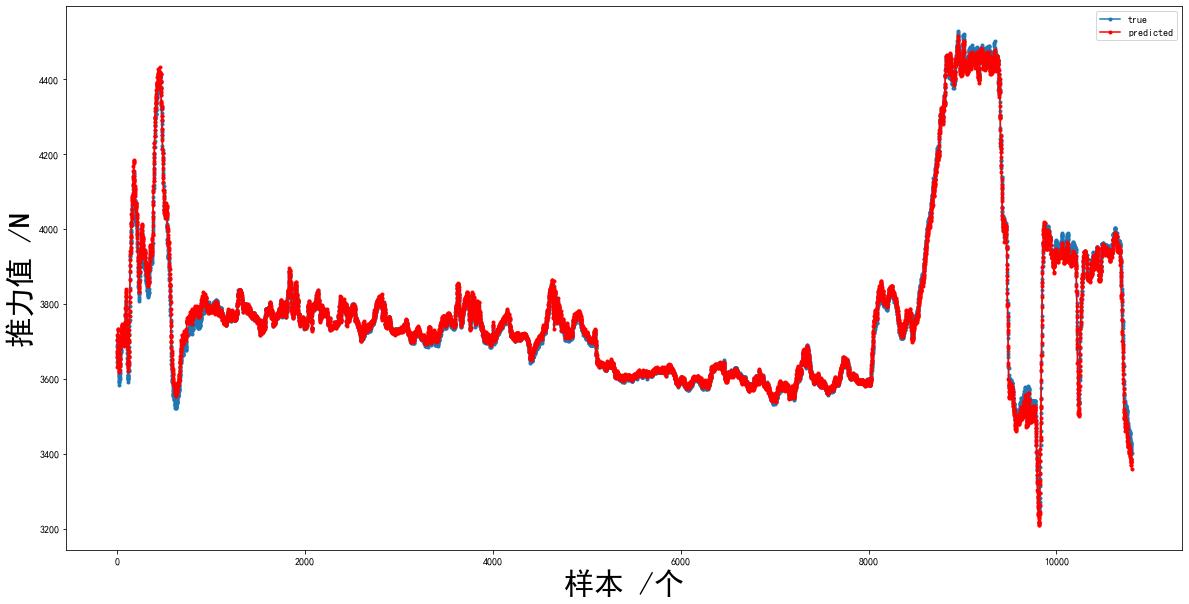

In [42]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();